In [1]:
import pandas as pd
import numpy as np
import warnings
import sys, os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from core.DICT import TYPE2NUM

label_path = '../../data/labels/full_non_transit_stopped_radar_labels.csv'
image_path = 'nontransit_track_images/'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

import warnings
warnings.filterwarnings("ignore", message="Failed to load image Python extension")

Using device: mps


#### CNNBaseline

In [3]:
BATCH_SIZE = 32
NUM_HIDDEN_1 = 32
NUM_HIDDEN_2 = 64
NUM_HIDDEN_3 = 128
IN_CHANNELS = 3

NUM_CLASSES = len(TYPE2NUM)

from dataloader_imgs import get_type_datasets
train_loader, val_loader, test_loader = get_type_datasets(label_path, image_path, batch_size = BATCH_SIZE)

In [4]:
import torch

all_labels = []

for _, labels in test_loader:
    all_labels.append(labels)

all_labels = torch.cat(all_labels)

# Convert to numpy array
labels_np = all_labels.numpy()

# Get unique labels and their counts
unique_labels, counts = np.unique(labels_np, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} samples")


Label 0: 62 samples
Label 1: 3 samples
Label 2: 21 samples
Label 3: 11 samples
Label 4: 2 samples
Label 5: 40 samples
Label 6: 29 samples


In [4]:
from models import CNNBaseline
from engine import train_model, save_model

cnn_baseline_1 = CNNBaseline(IN_CHANNELS, NUM_HIDDEN_1, NUM_HIDDEN_2, NUM_HIDDEN_3, NUM_CLASSES).to(device)
optimizer = optim.Adam(cnn_baseline_1.parameters(), lr=1e-4)
model_name = "nontransit_cnn_baseline_best_10"

train_config = {
    "model": cnn_baseline_1,
    "train_loader" : train_loader,
    "val_loader" : val_loader,
    "optimizer" : optimizer,
    "device" : device,
    "num_epochs" : 10,
    "scheduler": None
}

#train and save model
TRAIN_LOSSES, TRAIN_ACC, VAL_LOSSES, VAL_ACC, best_model_wts, best_val_loss = train_model(**train_config)
save_model(TRAIN_LOSSES, TRAIN_ACC, VAL_LOSSES, VAL_ACC, best_val_loss, best_model_wts, model_name)


TypeError: train_model() missing 1 required positional argument: 'start_epoch'

In [5]:
#Retrain for further epochs
cnn_baseline_1 = CNNBaseline(IN_CHANNELS, NUM_HIDDEN_1, NUM_HIDDEN_2, NUM_HIDDEN_3, NUM_CLASSES).to(device)

checkpoint_path = f"models/{model_name}.pth"
cnn_baseline_1.load_state_dict(torch.load(checkpoint_path))
optimizer = optim.Adam(cnn_baseline_1.parameters(), lr=1e-4)
model_name = "nontransit_cnn_baseline_best_20"

train_config_resume = {
    "model": cnn_baseline_1,
    "train_loader": train_loader,
    "val_loader": val_loader,
    "optimizer": optimizer,
    "device": device,
    "num_epochs": 10,
    "scheduler": None
}

# 5. Resume training
train_loss_2, train_acc_2, val_loss_2, val_acc_2, best_model_wts_2, best_val_loss_2 = train_model(**train_config_resume)
save_model(TRAIN_LOSSES, TRAIN_ACC, VAL_LOSSES, VAL_ACC, best_val_loss, best_model_wts, model_name)


Epoch 1/10
Train Loss: 1.2608 | Train Acc: 0.5124
Val   Loss: 1.3581 | Val   Acc: 0.4412


Epoch 2/10
Train Loss: 1.1791 | Train Acc: 0.5424
Val   Loss: 1.3505 | Val   Acc: 0.4882


Epoch 3/10
Train Loss: 1.1375 | Train Acc: 0.5621
Val   Loss: 1.3659 | Val   Acc: 0.4588


Epoch 4/10
Train Loss: 1.0781 | Train Acc: 0.5811
Val   Loss: 1.4219 | Val   Acc: 0.4235


Epoch 5/10
Train Loss: 1.0376 | Train Acc: 0.6060
Val   Loss: 1.4253 | Val   Acc: 0.4412


Epoch 6/10
Train Loss: 0.9729 | Train Acc: 0.6221
Val   Loss: 1.4652 | Val   Acc: 0.4412


Epoch 7/10
Train Loss: 0.8995 | Train Acc: 0.6623
Val   Loss: 1.4705 | Val   Acc: 0.4647


Epoch 8/10
Train Loss: 0.8575 | Train Acc: 0.6835
Val   Loss: 1.5046 | Val   Acc: 0.4471


Epoch 9/10
Train Loss: 0.7905 | Train Acc: 0.7032
Val   Loss: 1.5718 | Val   Acc: 0.4765


Epoch 10/10
Train Loss: 0.6831 | Train Acc: 0.7624
Val   Loss: 1.7150 | Val   Acc: 0.4647


### Resnet

In [18]:
from models import get_resnet50_classifier
from engine import train_model, save_model

resnet50 = get_resnet50_classifier(NUM_CLASSES).to(device)
optimizer = optim.Adam(resnet50.parameters(), lr=1e-3)
model_name = "nontransit_resnet50_best_50"
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_config = {
    "model": resnet50,
    "train_loader" : train_loader,
    "val_loader" : val_loader,
    "optimizer" : optimizer, 
    "device" : device,
    "start_epoch" : 0,
    "num_epochs" : 50,
    "scheduler": None
}

#train loop
TRAIN_LOSSES, TRAIN_ACC, VAL_LOSSES, VAL_ACC, best_model_wts, best_val_loss = train_model(**train_config)
save_model(TRAIN_LOSSES, TRAIN_ACC, VAL_LOSSES, VAL_ACC, best_val_loss, best_model_wts, model_name)

Epoch 1/50
Train Loss: 1.6180 | Train Acc: 0.3447
Val   Loss: 1.5953 | Val   Acc: 0.3452


Epoch 2/50
Train Loss: 1.4563 | Train Acc: 0.4519
Val   Loss: 1.5257 | Val   Acc: 0.4107


Epoch 3/50
Train Loss: 1.3845 | Train Acc: 0.4904
Val   Loss: 1.4488 | Val   Acc: 0.4167


Epoch 4/50
Train Loss: 1.3256 | Train Acc: 0.5074
Val   Loss: 1.4090 | Val   Acc: 0.4524


Epoch 5/50
Train Loss: 1.2734 | Train Acc: 0.5407
Val   Loss: 1.4026 | Val   Acc: 0.4345


Epoch 6/50
Train Loss: 1.2456 | Train Acc: 0.5355
Val   Loss: 1.3811 | Val   Acc: 0.4464


Epoch 7/50
Train Loss: 1.2213 | Train Acc: 0.5473
Val   Loss: 1.3917 | Val   Acc: 0.4524


Epoch 8/50
Train Loss: 1.1864 | Train Acc: 0.5643
Val   Loss: 1.3472 | Val   Acc: 0.4405


Epoch 9/50
Train Loss: 1.1731 | Train Acc: 0.5717
Val   Loss: 1.3399 | Val   Acc: 0.4702


Epoch 10/50
Train Loss: 1.1478 | Train Acc: 0.5865
Val   Loss: 1.3479 | Val   Acc: 0.4702


Epoch 11/50
Train Loss: 1.1102 | Train Acc: 0.6050
Val   Loss: 1.3208 | Val   Acc: 0.4821


Epoch 12/50
Train Loss: 1.0972 | Train Acc: 0.6109
Val   Loss: 1.3141 | Val   Acc: 0.4762


Epoch 13/50
Train Loss: 1.0945 | Train Acc: 0.6169
Val   Loss: 1.3068 | Val   Acc: 0.4940


Epoch 14/50
Train Loss: 1.0644 | Train Acc: 0.6243
Val   Loss: 1.2828 | Val   Acc: 0.5060


Epoch 15/50
Train Loss: 1.0531 | Train Acc: 0.6117
Val   Loss: 1.3013 | Val   Acc: 0.5060


Epoch 16/50
Train Loss: 1.0275 | Train Acc: 0.6428
Val   Loss: 1.3089 | Val   Acc: 0.4940


Epoch 17/50
Train Loss: 1.0262 | Train Acc: 0.6464
Val   Loss: 1.2822 | Val   Acc: 0.5000


Epoch 18/50
Train Loss: 1.0098 | Train Acc: 0.6420
Val   Loss: 1.2831 | Val   Acc: 0.4762


Epoch 19/50
Train Loss: 0.9957 | Train Acc: 0.6457
Val   Loss: 1.2590 | Val   Acc: 0.5000


Epoch 20/50
Train Loss: 0.9776 | Train Acc: 0.6709
Val   Loss: 1.2664 | Val   Acc: 0.4940


Epoch 21/50
Train Loss: 0.9476 | Train Acc: 0.6738
Val   Loss: 1.2635 | Val   Acc: 0.5060


Epoch 22/50
Train Loss: 0.9514 | Train Acc: 0.6686
Val   Loss: 1.2527 | Val   Acc: 0.4881


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/liuzehan/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/jm/bv3tgs257hx9tx764_p9xq0w0000gn/T/ipykernel_72996/4254320449.py", line 21, in <module>
    TRAIN_LOSSES, TRAIN_ACC, VAL_LOSSES, VAL_ACC, best_model_wts, best_val_loss = train_model(**train_config)
                                                                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/liuzehan/Desktop/Protected Seas/peter/CNN/engine.py", line 55, in train_model
  File "/Users/liuzehan/miniconda3/lib/python3.11/site-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/Users/liuzehan/miniconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 733, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/Users/liuzehan/miniconda3/lib/python3.11/site-packages

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evaluate_model(model: nn.Module,
                   test_loader,
                   device: torch.device,
                   NUM2TYPE: dict[str],
                   loss_fn: nn.Module = nn.CrossEntropyLoss()) -> None:
    """
    Evaluate the model and print classification report + plot confusion matrices.

    Args:
        model (nn.Module): Trained model to evaluate.
        test_loader (DataLoader): DataLoader for test data.
        device (torch.device): Device to run the evaluation on.
        NUM2TYPE (dict): Mapping from class integers to readable string labels.
        loss_fn (nn.Module): Loss function. Defaults to CrossEntropyLoss.
    """
    model.eval()
    all_preds = []
    all_targets = []
    running_loss = 0.0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            total += targets.size(0)

    all_preds_str = [NUM2TYPE[p] for p in all_preds]
    all_targets_str = [NUM2TYPE[t] for t in all_targets]

    print("\nClassification Report:")
    report = classification_report(all_targets_str, all_preds_str, digits=4)
    print(report)

    cm = confusion_matrix(all_targets_str, all_preds_str, labels=list(NUM2TYPE.values()))
    cm_df = pd.DataFrame(cm, index=NUM2TYPE.values(), columns=NUM2TYPE.values())

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (Counts)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm_norm_df = pd.DataFrame(cm_norm, index=NUM2TYPE.values(), columns=NUM2TYPE.values())

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_norm_df, annot=True, fmt='.2f', cmap='Greens')
    plt.title("Confusion Matrix (Sensitivity / Recall)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Classification Report:
                precision    recall  f1-score   support

  cargo/tanker     0.0000    0.0000    0.0000         3
       class_b     0.5405    0.6452    0.5882        62
  fishing_boat     0.5476    0.5750    0.5610        40
 military_ship     0.0000    0.0000    0.0000         2
         other     0.4848    0.5517    0.5161        29
passenger_ship     0.3571    0.2381    0.2857        21
       tug/tow     1.0000    0.4545    0.6250        11

      accuracy                         0.5298       168
     macro avg     0.4186    0.3521    0.3680       168
  weighted avg     0.5237    0.5298    0.5164       168



/Users/liuzehan/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


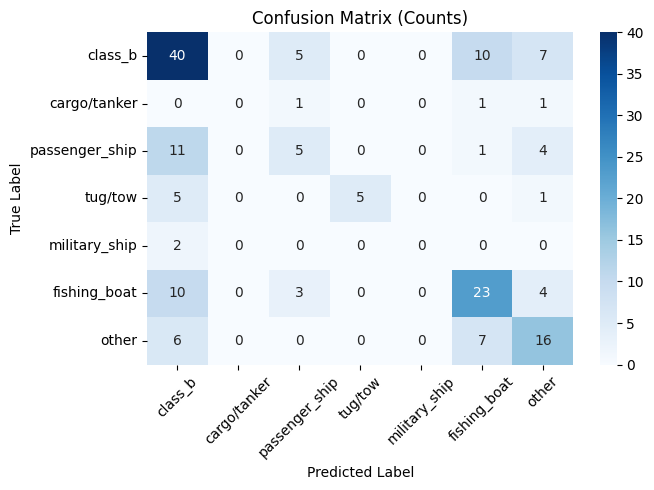

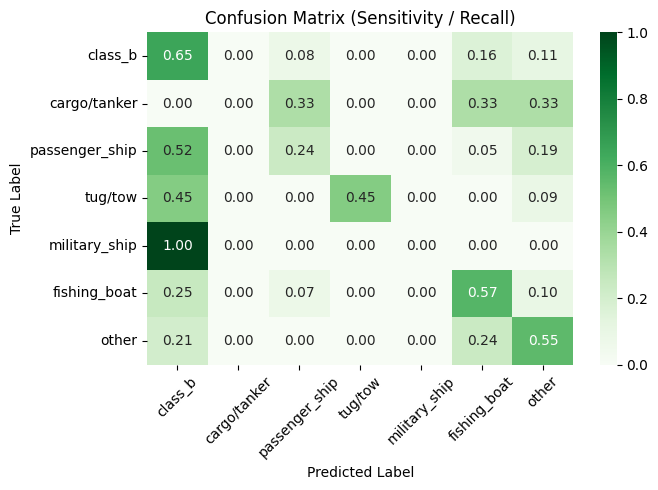

In [17]:
#load best model
sys.path.append(os.path.abspath('..'))
from core.DICT import NUM2TYPE

model_path = "models/nontransit_resnet50_best_50.pth"
resnet50_best = resnet50.load_state_dict(torch.load(model_path))

evaluate_model(resnet50, test_loader, device, NUM2TYPE)